# Probability and Random Processes - Assignment 2

### Importing Packages

In [1]:
#Importing packages
import cv2 as cv
from scipy.fftpack import fft2, fftshift, ifft2, ifftshift
from skimage.measure import compare_mse, compare_psnr
from scipy.special import j1 as bessel1D
import scipy.stats as st

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from math import log
import os

import warnings
warnings.filterwarnings("ignore")

### Kernel to apply a Gaussian Defocus Blur

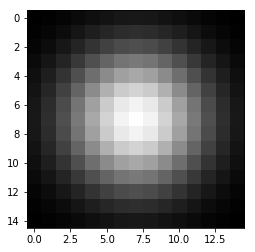

In [2]:
#defining a gaussian kernel to defocus the image
def gaussian_kernel(klen=15, nsig=3):    
    irange = (2*nsig+1.)/(klen)
    x = np.linspace(-nsig-irange/2., nsig+irange/2., klen+1)
    kernel = np.diff(st.norm.cdf(x))
    kernel = np.sqrt(np.outer(kernel, kernel))
    kernel = kernel/kernel.sum()
    return kernel

plt.imshow(gaussian_kernel(), cmap='gray')

### Function to add defocus blur

In [3]:
#Blurring an image in frequency domain using fourier transform and inverse fourier transform
def blur_image(image, klen = 15, nsig = 3):
    image2 = np.array(image)
    h = gaussian_kernel(klen, nsig)
    h = np.fft.fft2(h, image.shape)

    image2 = np.fft.fft2(image2)
    image2 = image2 * h
    image2 = np.fft.ifft2(image2).real
    return(image2)

### Inverse filter

In [4]:
#Deblurring an image in frequency domain using fourier transform and inverse fourier transform using naive inverse filter
def deblur_inverse(image2):
    image3 = np.fft.fft2(image2)
    h = gaussian_kernel()
    h = np.fft.fft2(h, image2.shape)
    image3 = image3 / h
    image3 = np.fft.ifft2(image3).real
    return(image3)

### Wiener filter

In [5]:
#Deblurring an image in frequency domain using fourier transform and inverse fourier transform using wiener filter
def deblur_wiener(image2, k):
    h = gaussian_kernel()
    h = np.fft.fft2(h, image2.shape)
    hh = (1/h)*(np.abs(h)**2)/((np.abs(h)**2) + k)
    image4 = np.fft.fft2(image2)
    image4 = image4 * hh
    image4 = np.fft.ifft2(image4).real
    return(image4)

### Richardson Lucy filter

In [6]:
#richarson Lucy filter
def richardsonLucy(img, iterations=100):
    f = img
    kernel = gaussian_kernel()
    blur_kernel = np.matrix(kernel)
    kernel_mirror = blur_kernel.T

    for _ in range(iterations):
        f = f + cv.filter2D(img - cv.filter2D(f,-1, blur_kernel), -1, kernel_mirror)
    return f

### Function to add additive gaussian noise

In [7]:
#Gaussian additive noise
def noise(image2, sigma = 0.01):
    img_shape_y, img_shape_x = image2.shape
    mean = 0
    gauss_noise = np.random.normal(mean,sigma,(img_shape_y,img_shape_x,1))
    gauss_noise = gauss_noise.reshape(img_shape_y,img_shape_x)
    return(gauss_noise)

### Reading image

In [8]:
# read an image, convert to grayscale and floating point (in range 0-1)
image = cv.imread('elephant.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
# double check the image attributes
print('Image size is', image.shape, 'and data type is', image.dtype)

Image size is (600, 800) and data type is float64


### Deblurring Image (no noise) 

MSE(original image, blurred image): 0.012258885837232815
MSE(original image, image deblurred with inverse filter): 1.1104677330963906e-20
MSE(original image, image deblurred with wiener filter): 0.0017660295461808266
MSE(original image, image deblurred with richardsonlucy filter): 0.015007716661034544

PSNR(original image, blurred image:) 67.28028929995122
PSNR(original image, image deblurred with inverse filter:) 247.70973986867324
PSNR(original image, image deblurred with wiener filter:) 75.69481965450126
PSNR(original image, image deblurred with richardsonlucy filter:) 66.40165308796517
MSE(original image, blurred image): 0.013745705629581726
MSE(original image, image deblurred with inverse filter): 1.3587400401175628e-18
MSE(original image, image deblurred with wiener filter): 0.00029443851804688675
MSE(original image, image deblurred with richardsonlucy filter): 0.017469097945690855

PSNR(original image, blurred image:) 66.78312891561147
PSNR(original image, image deblurred with i

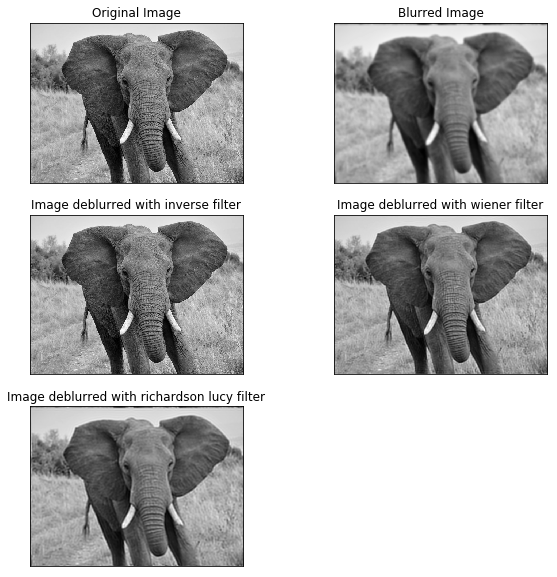

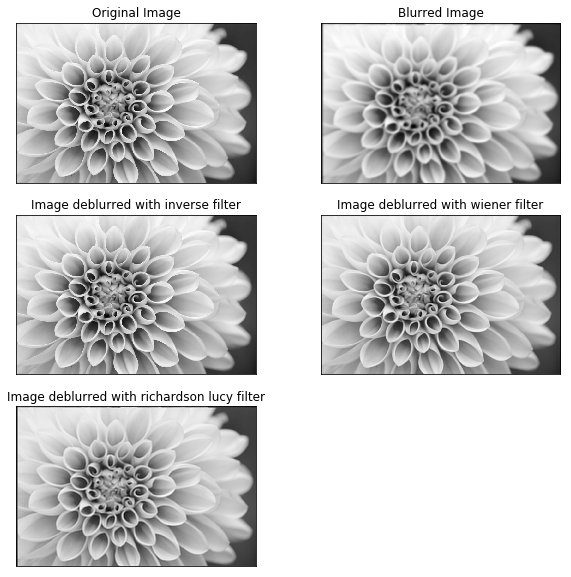

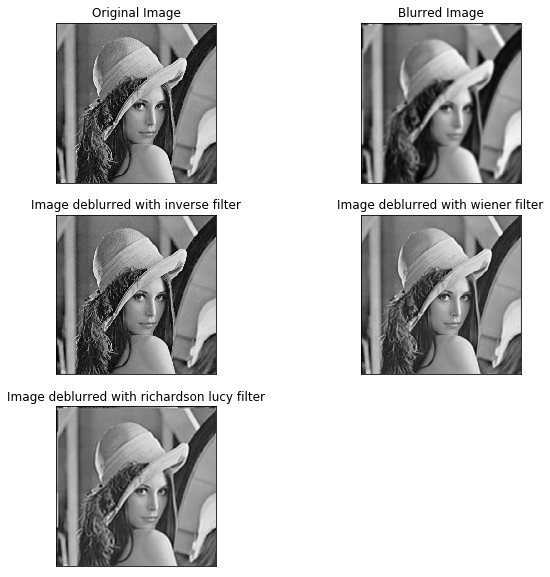

In [9]:
for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):
    #Reading the image
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    
    #Blurring the image
    blur_img = blur_image(image)

    #Deblurring with inverse filter
    deblur_inv = deblur_inverse(blur_img)

    #Deblurring with wiener filter
    deblur_w = deblur_wiener(blur_img, 0.0001)

    #Deblurring with richardsonlucy filter
    img_rl = richardsonLucy(np.abs(blur_img)).real

    #Plotting images
    plt.rcParams['figure.figsize']=(10,10)

    fig = plt.figure()

    fig_orgl = fig.add_subplot(321)
    fig_orgl.set_title('Original Image')
    fig_orgl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_orgl.imshow(image,cmap='gray')

    fig_blur = fig.add_subplot(322)
    fig_blur.set_title('Blurred Image')
    fig_blur.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_blur.imshow(blur_img,cmap='gray')

    fig_deblur_inv = fig.add_subplot(323)
    fig_deblur_inv.set_title('Image deblurred with inverse filter')
    fig_deblur_inv.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_inv.imshow(deblur_inv,cmap='gray')

    fig_deblur_w = fig.add_subplot(324)
    fig_deblur_w.set_title('Image deblurred with wiener filter')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w,cmap='gray')

    fig_deblur_w = fig.add_subplot(325)
    fig_deblur_w.set_title('Image deblurred with richardson lucy filter')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(img_rl,cmap='gray')

    #calculating MSE and PSNR
    print("MSE(original image, blurred image):", compare_mse(np.abs(image), np.abs(blur_img)))
    print("MSE(original image, image deblurred with inverse filter):", compare_mse(np.abs(image), np.abs(deblur_inv)))
    print("MSE(original image, image deblurred with wiener filter):", compare_mse(np.abs(image), np.abs(deblur_w)))
    print("MSE(original image, image deblurred with richardsonlucy filter):", compare_mse(np.abs(image), np.abs(img_rl)))
    print()
    print("PSNR(original image, blurred image:)", compare_psnr(np.abs(image), np.abs(blur_img), 256))
    print("PSNR(original image, image deblurred with inverse filter:)", compare_psnr(np.abs(image), np.abs(deblur_inv), 256))
    print("PSNR(original image, image deblurred with wiener filter:)", compare_psnr(np.abs(image), np.abs(deblur_w), 256))
    print("PSNR(original image, image deblurred with richardsonlucy filter:)", compare_psnr(np.abs(image), np.abs(img_rl), 256))

### Calculating Noise to Signal ratio (NSR)

In [10]:
#calculating the noise to signal ratio
def NSR(image, noise):
    N = np.abs(fft2(noise))**2
    S = np.abs(fft2(image))**2
    NSR = N/S
    return(NSR)

### Deblurring image (noise)

MSE(original image, blurred image): 0.012258885837232815
MSE(original image, image deblurred with inverse filter): 163595881.71315953
MSE(original image, image deblurred with wiener filter(known NSR)): 0.0026146383217566173
MSE(original image, image deblurred with wiener filter(unknown NSR)): 0.0035731925606197782
MSE(original image, image deblurred with richardson lucy): 0.01522824769663777

PSNR(original image, blurred image): 67.28028929995122
PSNR(original image, image deblurred with inverse filter): -33.97292436121375
PSNR(original image, image deblurred with wiener filter(known NSR)): 72.63423509506289
PSNR(original image, image deblurred with wiener filter(unknown NSR)): 72.63423509506289
PSNR(original image, image deblurred with richardson lucy): 66.3382999836211
MSE(original image, blurred image): 0.013745705629581726
MSE(original image, image deblurred with inverse filter): 4355879997.951387
MSE(original image, image deblurred with wiener filter(known NSR)): 0.000662617492059

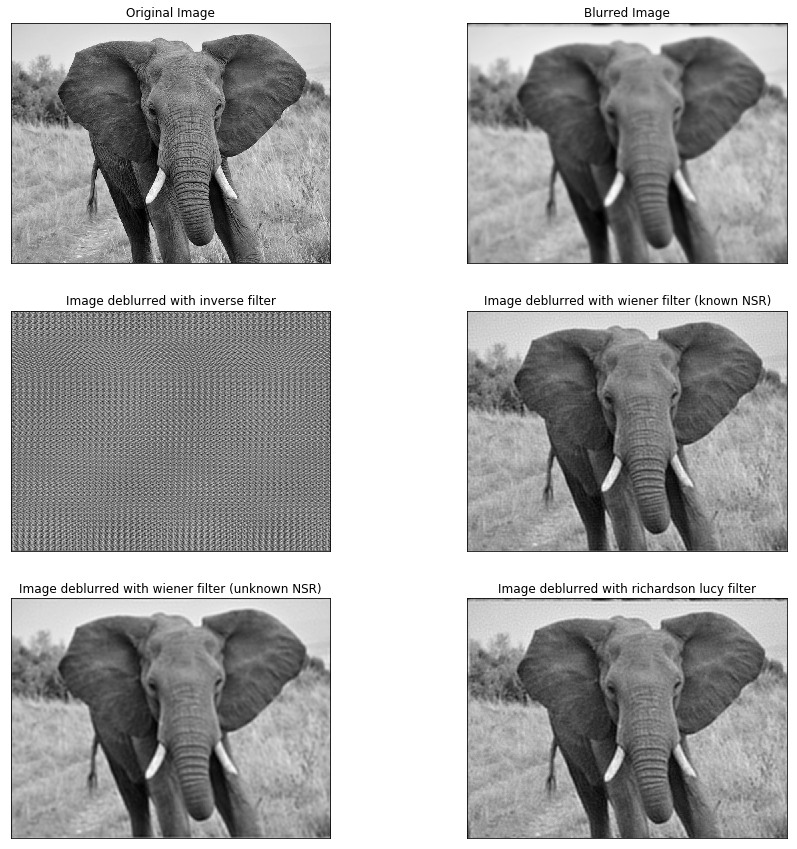

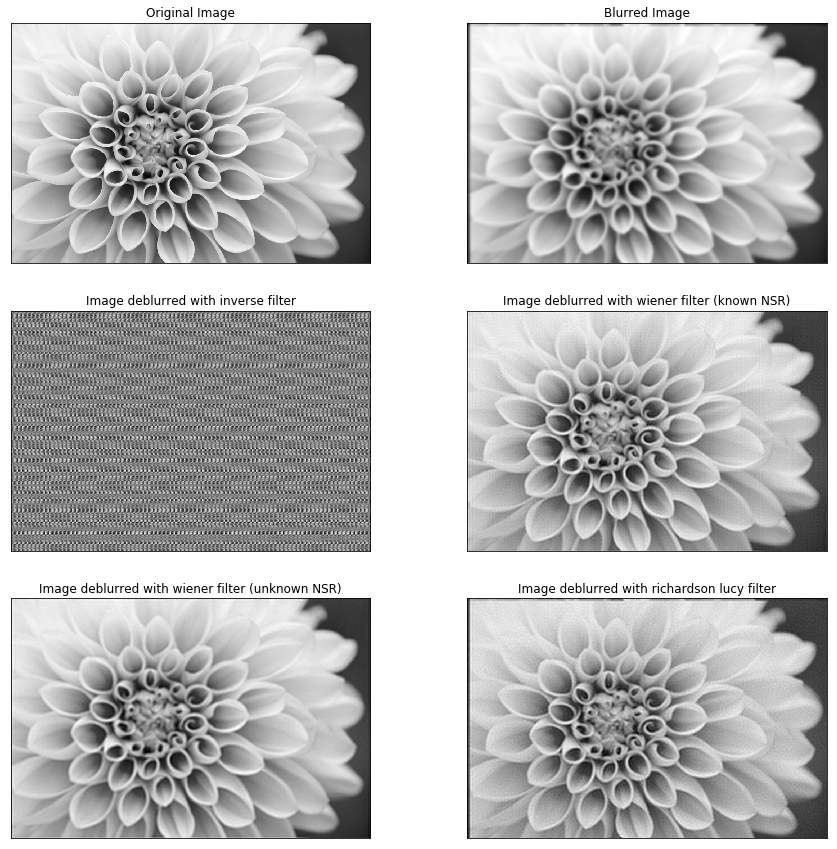

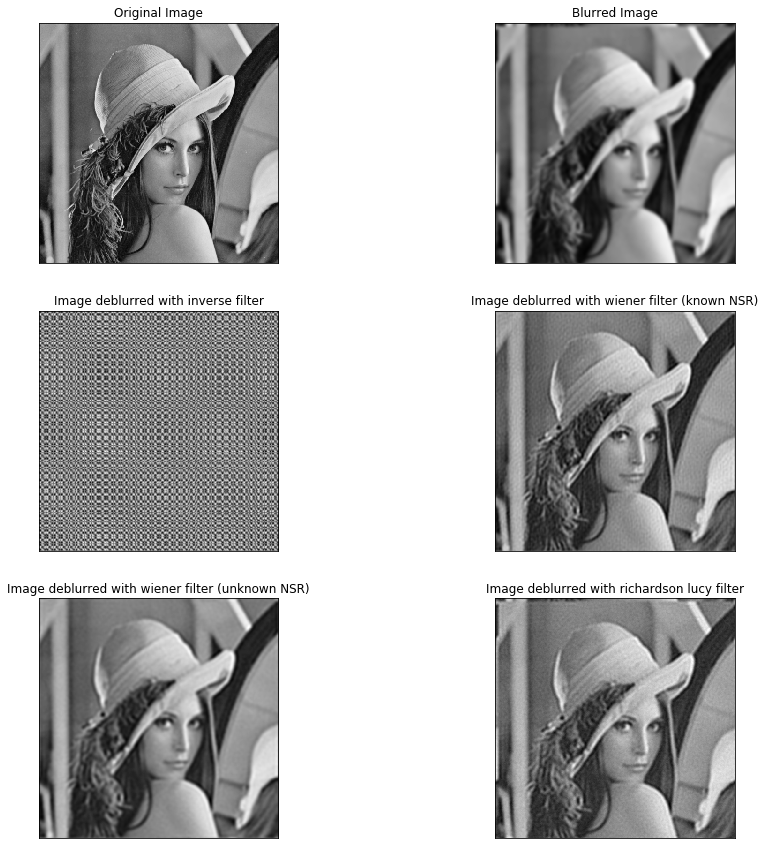

In [11]:
for imagefile in filter(lambda x: x.endswith('.jpg'), os.listdir('.')):

    #Reading the images
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    #blurring the image
    blur_img = blur_image(image)

    #gaussian additive noise
    noise_ = noise(blur_img)

    #adding noise to image
    noisy_img = blur_img + noise_

    #deblurring using inverse filter
    deblur_inv = deblur_inverse(noisy_img)

    #deblurring using weiner filter
    nsr = NSR(image, noise_)
    deblur_w_nsr = deblur_wiener(noisy_img, nsr)
    deblur_w = deblur_wiener(noisy_img, 0.042) #k can be calculated experimentally

    #Deblurring with richardsonlucy filter
    img_rl = richardsonLucy(np.abs(noisy_img)).real

    #plotting images
    plt.rcParams['figure.figsize']=(15,15)

    fig = plt.figure()

    fig_orgl = fig.add_subplot(321)
    fig_orgl.set_title('Original Image')
    fig_orgl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_orgl.imshow(image,cmap='gray')

    fig_blur = fig.add_subplot(322)
    fig_blur.set_title('Blurred Image')
    fig_blur.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_blur.imshow(blur_img,cmap='gray')

    fig_deblur_inv = fig.add_subplot(323)
    fig_deblur_inv.set_title('Image deblurred with inverse filter')
    fig_deblur_inv.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_inv.imshow(deblur_inv,cmap='gray')

    fig_deblur_w = fig.add_subplot(324)
    fig_deblur_w.set_title('Image deblurred with wiener filter (known NSR)')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w_nsr,cmap='gray')

    fig_deblur_w = fig.add_subplot(325)
    fig_deblur_w.set_title('Image deblurred with wiener filter (unknown NSR)')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(deblur_w,cmap='gray')

    fig_deblur_w = fig.add_subplot(326)
    fig_deblur_w.set_title('Image deblurred with richardson lucy filter')
    fig_deblur_w.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig_deblur_w.imshow(img_rl,cmap='gray')

    #calculating MSE and PSNR
    print("MSE(original image, blurred image):", compare_mse(np.abs(image), np.abs(blur_img)))
    print("MSE(original image, image deblurred with inverse filter):", compare_mse(np.abs(image), np.abs(deblur_inv)))
    print("MSE(original image, image deblurred with wiener filter(known NSR)):", compare_mse(np.abs(image), np.abs(deblur_w_nsr)))
    print("MSE(original image, image deblurred with wiener filter(unknown NSR)):", compare_mse(np.abs(image), np.abs(deblur_w)))
    print("MSE(original image, image deblurred with richardson lucy):", compare_mse(np.abs(image), np.abs(img_rl)))
    print()
    print("PSNR(original image, blurred image):", compare_psnr(np.abs(image), np.abs(blur_img), 256))
    print("PSNR(original image, image deblurred with inverse filter):", compare_psnr(np.abs(image), np.abs(deblur_inv), 256))
    print("PSNR(original image, image deblurred with wiener filter(known NSR)):", compare_psnr(np.abs(image), np.abs(deblur_w),256))
    print("PSNR(original image, image deblurred with wiener filter(unknown NSR)):", compare_psnr(np.abs(image), np.abs(deblur_w),256))
    print("PSNR(original image, image deblurred with richardson lucy):", compare_psnr(np.abs(image), np.abs(img_rl),256))

### Plotting the graphs

In [12]:
import matplotlib.pyplot as plt
import os 

l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []

def evaluate(filename,blur):
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    newimage = blur_image(image, blur*5, blur)    
    
    image_1 = deblur_inverse(newimage)  
    image_2 = deblur_wiener(newimage, 0.042)
    image_3 = richardsonLucy(newimage)
    
    l1.append(compare_mse(image,image_1))
    l2.append(compare_mse(image,image_2))
    l3.append(compare_mse(image,image_3))
    l4.append(compare_psnr(image,image_1, 256))
    l5.append(compare_psnr(image,image_2, 256))
    l6.append(compare_psnr(image,image_3, 256))
    
    return
    
for i in range(4,18):
    evaluate("elepahnt.jpg",i)

In [13]:
print(l1)
print(l2)
print(l3)
print(l4)
print(l5)
print(l6)

[0.008886863779218861, 0.015884039250282957, 0.022719042561876353, 0.029157031410782963, 0.0347086428681629, 0.039523107000418854, 0.04395244856881242, 0.04831736106506205, 0.052302489310311756, 0.05587091707703638, 0.058679859787677355, 0.060828960835854866, 0.062436087407093374, 0.063732204503933]
[0.0061518467867008614, 0.013610584698617027, 0.020703336201481706, 0.026842697905435555, 0.032247419622051174, 0.03695211577061735, 0.04127914232120448, 0.04544919462226941, 0.04934432938289265, 0.052727910905230845, 0.055443814109515405, 0.057526920070015, 0.05913624435252637, 0.06036536651118043]
[0.02742383793996828, 0.03309960697394547, 0.037984582111757585, 0.0424618344775182, 0.046806677653842256, 0.05091260084406691, 0.054585379708757355, 0.0575627378336077, 0.059825892363153936, 0.06156380791829353, 0.06292601767356934, 0.06388640037822556, 0.06442889659098978, 0.06479886962699652]
[68.67731407413568, 66.1551897906639, 64.60089905470959, 63.51736625914151, 62.76042297833612, 62.196

### Increasing blur vs MSE (images with no noise)

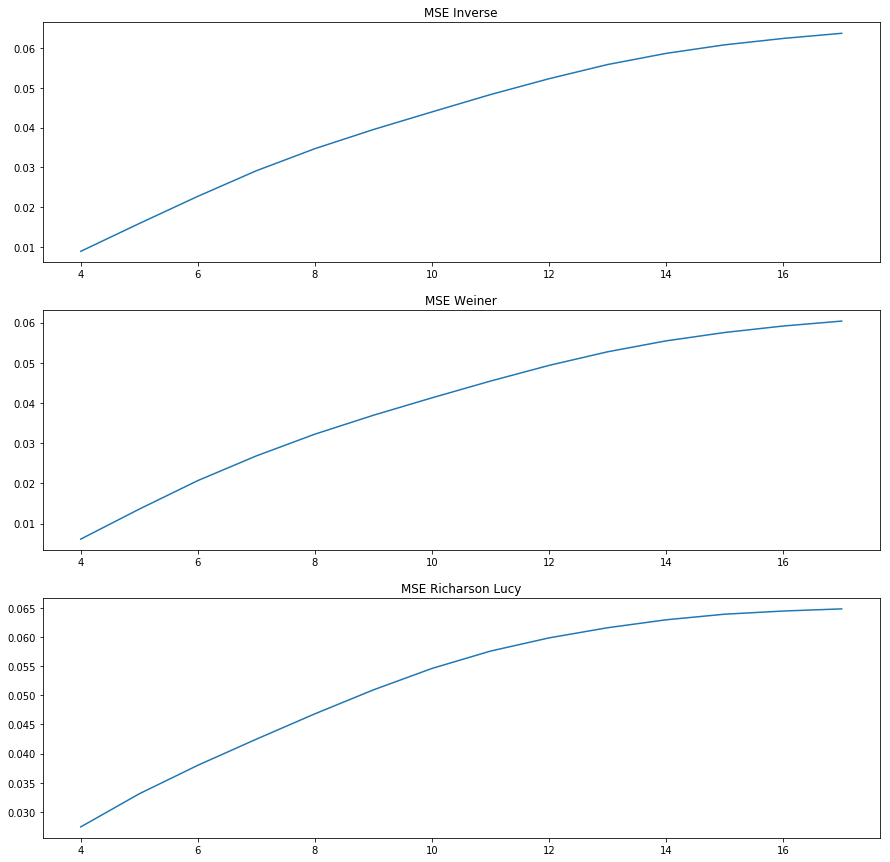

In [14]:
x = [4,5,6,7,8,9,10,11,12,13,14, 15, 16, 17]
fig = plt.figure()
figl = fig.add_subplot(311)
figl.set_title('MSE Inverse')
#figl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
figl.plot(x[:],l1[:])

fig2 = fig.add_subplot(312)
fig2.set_title('MSE Weiner')
#fig2.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig2.plot(x[:],l2[:])

fig3 = fig.add_subplot(313)
fig3.set_title('MSE Richarson Lucy')
#fig3.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig3.plot(x[:],l3[:])

### Increasing blur vs PSNR (images with noise)

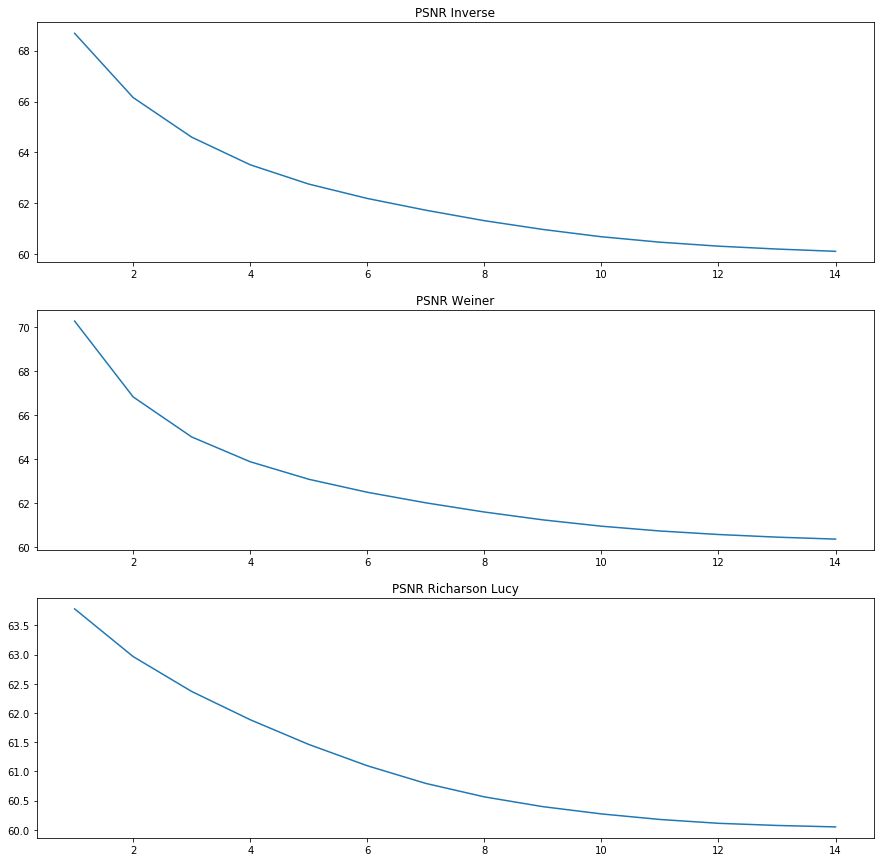

In [15]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
fig = plt.figure()
figl = fig.add_subplot(311)
figl.set_title('PSNR Inverse')
#figl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
figl.plot(x[:],l4[:])

fig2 = fig.add_subplot(312)
fig2.set_title('PSNR Weiner')
#fig2.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig2.plot(x[:],l5[:])

fig3 = fig.add_subplot(313)
fig3.set_title('PSNR Richarson Lucy')
#fig3.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig3.plot(x[:],l6[:])


In [16]:
import matplotlib.pyplot as plt
import os 

l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []

def evaluate(filename,sig):
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    newimage = blur_image(image)    
    n = noise(image, sig)
    newimage = newimage + n
    
    image_1 = deblur_inverse(newimage)  
    image_2 = deblur_wiener(newimage, 0.042)
    image_3 = richardsonLucy(newimage)
    
    l1.append(compare_mse(image,image_1))
    l2.append(compare_mse(image,image_2))
    l3.append(compare_mse(image,image_3))
    l4.append(compare_psnr(image,image_1, 256))
    l5.append(compare_psnr(image,image_2, 256))
    l6.append(compare_psnr(image,image_3, 256))
    
    return
    
for i in range(1, 15):
    evaluate("elepahnt.jpg",0.01*i)

In [17]:
print(l1)
print(l2)
print(l3)
print(l4)
print(l5)
print(l6)

[29808886566.697666, 775570007479.3987, 664246687347.9174, 1912483082530.5356, 1809005210324.8345, 264607910914.95267, 975714237834.2108, 4082551418127.9536, 3017747111415.237, 15997528477060.373, 30912294453437.05, 20760706457896.305, 14106474847611.297, 16817260395773.03]
[0.0023759768738794286, 0.0024184468963451508, 0.002493690726868935, 0.0026216280987641136, 0.0027616854597816605, 0.002945216617882245, 0.003129059322443171, 0.003378984630465075, 0.003648102287856307, 0.0040006137681514245, 0.004317072600830452, 0.0046160651883968, 0.0050752219128615585, 0.005535927796527496]
[0.021994086179108883, 0.022631165581247933, 0.023725271530840975, 0.025178033719759976, 0.02717075774216411, 0.02938739581982473, 0.032254821571397085, 0.035430600071408996, 0.03901117638522425, 0.04371016599734745, 0.047573789228196814, 0.05214878459298442, 0.05769999089337271, 0.0641519551860696]
[-56.57865823772901, -70.73141075252215, -70.05849466602226, -74.65117671530776, -74.40959887099612, -66.061228

### Increasing noise vs MSE 

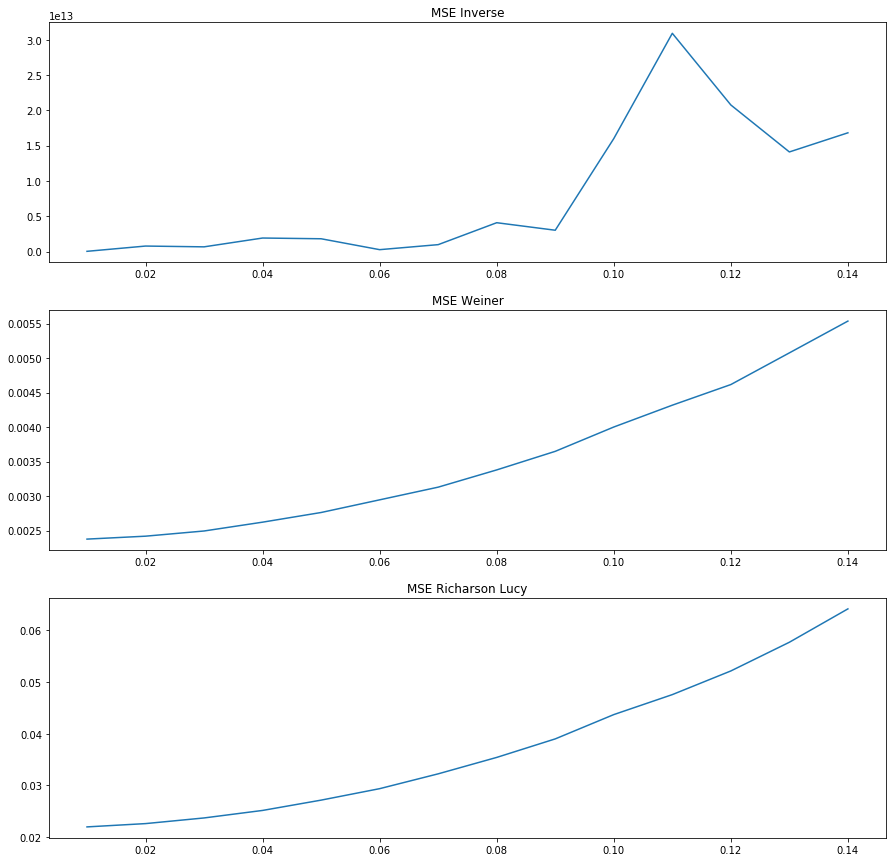

In [18]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()
figl = fig.add_subplot(311)
figl.set_title('MSE Inverse')
#figl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
figl.plot(x[:],l1[:])

fig2 = fig.add_subplot(312)
fig2.set_title('MSE Weiner')
#fig2.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig2.plot(x[:],l2[:])

fig3 = fig.add_subplot(313)
fig3.set_title('MSE Richarson Lucy')
#fig3.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig3.plot(x[:],l3[:])

### Increasing noise vs PSNR

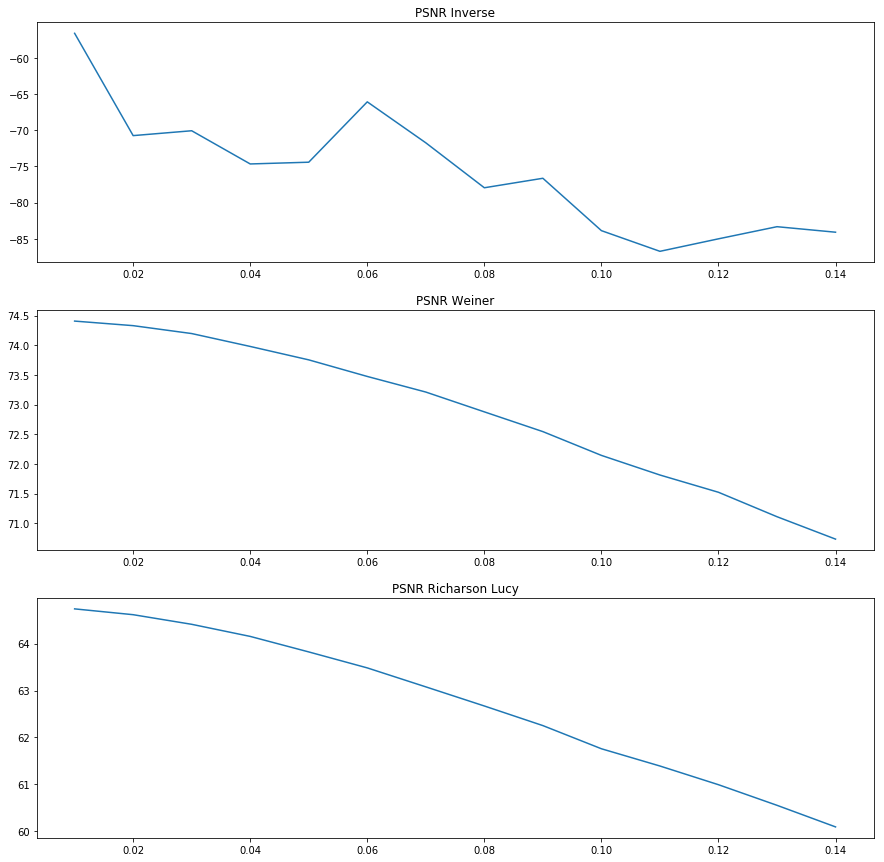

In [19]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()
figl = fig.add_subplot(311)
figl.set_title('PSNR Inverse')
#figl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
figl.plot(x[:],l4[:])

fig2 = fig.add_subplot(312)
fig2.set_title('PSNR Weiner')
#fig2.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig2.plot(x[:],l5[:])

fig3 = fig.add_subplot(313)
fig3.set_title('PSNR Richarson Lucy')
#fig3.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig3.plot(x[:],l6[:])


In [20]:
import matplotlib.pyplot as plt
import os 

l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []

def evaluate(filename,blur):
    image = cv.imread(imagefile)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)/255
    newimage = blur_image(image, blur*5, blur)
    n = noise(image)
    newimage = newimage + n
    
    image_1 = deblur_inverse(newimage)  
    image_2 = deblur_wiener(newimage, 0.042)
    image_3 = richardsonLucy(newimage)
    
    l1.append(compare_mse(image,image_1))
    l2.append(compare_mse(image,image_2))
    l3.append(compare_mse(image,image_3))
    l4.append(compare_psnr(image,image_1, 256))
    l5.append(compare_psnr(image,image_2, 256))
    l6.append(compare_psnr(image,image_3, 256))
    
    return
    
for i in range(4,18):
    evaluate("elepahnt.jpg",i)

In [21]:
print(l1)
print(l2)
print(l3)
print(l4)
print(l5)
print(l6)

[26458771392.76655, 92268276061.63771, 41621291955.76251, 37286529456.35516, 84258159318.96628, 48538686401.67985, 63809498524.172806, 48450903126.584526, 74159295805.20518, 23410997743.43823, 38637743040.95825, 84147828399.59215, 119641990712.8924, 190815822715.95996]
[0.006172295003975021, 0.013633673256518519, 0.020717411763600455, 0.026863828930414366, 0.032273742368292516, 0.036961348553054704, 0.041307621602930694, 0.04547375543066843, 0.04935525128209749, 0.05274303046487575, 0.05545770305573731, 0.05753223994027392, 0.059138129455764604, 0.06037751796247741]
[0.02763617104513873, 0.03330740252634112, 0.0381830530408218, 0.04269912050300154, 0.0470400045444031, 0.05112769667245387, 0.054809429367411615, 0.057770167288272174, 0.06003646153715227, 0.06177293844545604, 0.06314344908581651, 0.0641119937312562, 0.06463757506688929, 0.06501174349055616]
[-56.06089743327178, -61.48572475715123, -58.02835626283867, -57.550720314960664, -61.091320367905865, -58.6960808825682, -59.8840540

### Increasing blur vs MSE (images with noise)

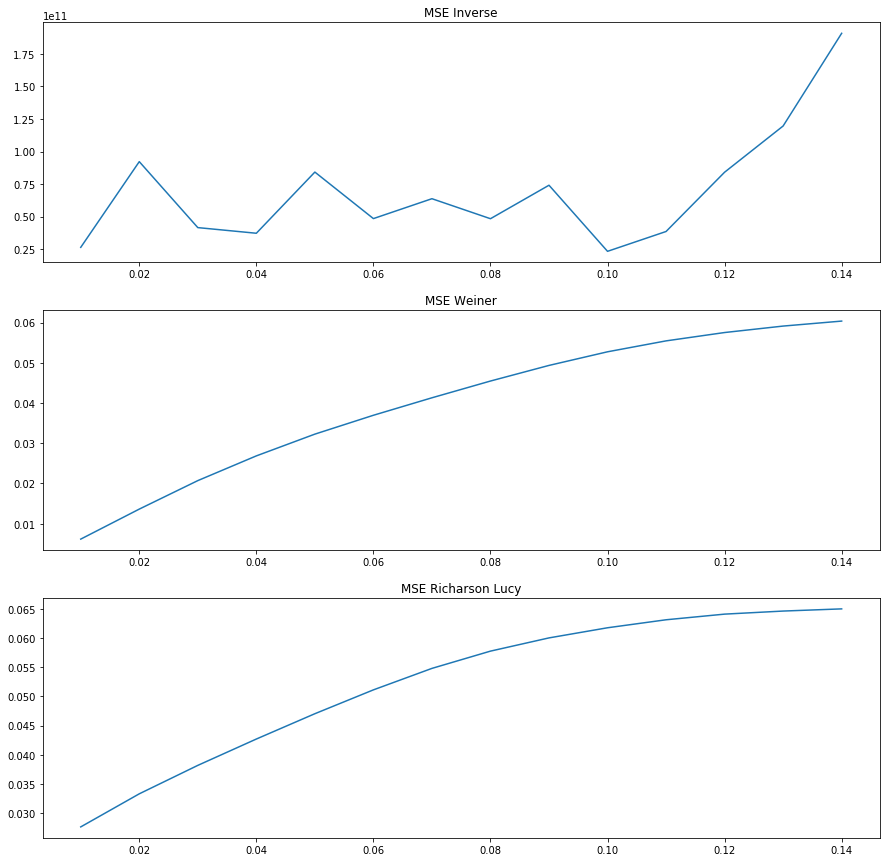

In [22]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()
figl = fig.add_subplot(311)
figl.set_title('MSE Inverse')
#figl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
figl.plot(x[:],l1[:])

fig2 = fig.add_subplot(312)
fig2.set_title('MSE Weiner')
#fig2.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig2.plot(x[:],l2[:])

fig3 = fig.add_subplot(313)
fig3.set_title('MSE Richarson Lucy')
#fig3.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig3.plot(x[:],l3[:])

### Increasing blur vs PSNR (images with noise)

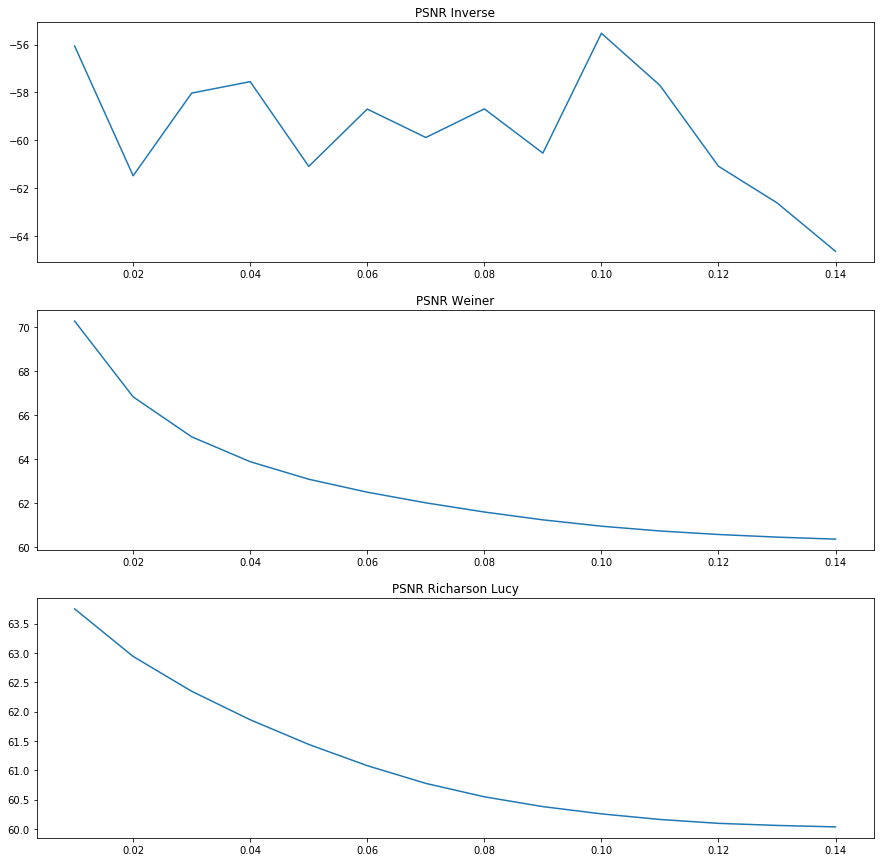

In [23]:
x = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14]
fig = plt.figure()
figl = fig.add_subplot(311)
figl.set_title('PSNR Inverse')
#figl.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
figl.plot(x[:],l4[:])

fig2 = fig.add_subplot(312)
fig2.set_title('PSNR Weiner')
#fig2.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig2.plot(x[:],l5[:])

fig3 = fig.add_subplot(313)
fig3.set_title('PSNR Richarson Lucy')
#fig3.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
fig3.plot(x[:],l6[:])
